In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

%matplotlib inline

In [2]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'cleaned_data_with_id.csv')
df = pd.read_csv(data_path)
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,id,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Month,Day_in_week,Points (Total),Points (Ind for each Artist/Nat)
0,3qQbCzHBycnDpGskqOWY0E,0.668,0.758,0.033,0.483,0.000,0.834,-5176.0,5,0,200,100.0
1,7ro0hRteUMfnOioTFI5TG1,0.652,0.800,0.061,0.143,0.629,0.234,-4019.0,5,0,199,199.0
2,2UW7JaomAMuX9pZrjVpHAU,0.812,0.479,0.333,0.213,0.000,0.559,-5678.0,5,0,198,99.0
3,7FbrGaHYVDmfr7KoLIZnQ7,0.783,0.592,0.033,0.435,0.000,0.726,-8332.0,5,0,197,197.0
4,6pD0ufEQq0xdHSsRbg9LBK,0.569,0.724,0.047,0.228,0.000,0.562,-4076.0,5,0,196,98.0


In [3]:
df_features = df.drop(columns=["Day_in_week", "Points (Ind for each Artist/Nat)"]).copy()

# df_features.loc[df_features["Month"] >= 5, "weekend"] = True
# df_features.loc[df_features["Month"] < 5, "weekend"] = False
# df_features.drop(columns=["Month"], inplace=True)

In [4]:
df_features.describe()

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Month,Points (Total)
count,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000,397093.000000
mean,0.687648,0.635749,0.108135,0.239417,0.009306,0.505615,-6113.682344,6.321300,98.353683
std,0.138301,0.160411,0.099221,0.242882,0.060398,0.225206,2352.469501,3.478906,56.853528
min,0.073000,0.005000,0.022000,0.000000,0.000000,0.026000,-34475.000000,1.000000,1.000000
25%,0.601000,0.532000,0.043000,0.048000,0.000000,0.335000,-7258.000000,3.000000,49.000000
50%,0.704000,0.652000,0.064000,0.154000,0.000000,0.497000,-5723.000000,6.000000,98.000000
75%,0.787000,0.760000,0.131000,0.367000,0.000000,0.681000,-4486.000000,9.000000,147.000000
max,0.985000,0.996000,0.966000,0.994000,0.956000,0.982000,-1167.000000,12.000000,200.000000


In [5]:
# Norm / Standardise the data
features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Loudness']
df_features[features] = (df_features[features] - df_features[features].mean())/df_features[features].std()
df_features.head()

,id,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Month,Points (Total)
0,3qQbCzHBycnDpGskqOWY0E,-0.142069,0.762116,-0.757242,1.002888,-0.154079,1.458156,0.398595,5,200
1,7ro0hRteUMfnOioTFI5TG1,-0.257758,1.023944,-0.475044,-0.396971,10.260230,-1.206074,0.890418,5,199
2,2UW7JaomAMuX9pZrjVpHAU,0.899136,-0.977171,2.266300,-0.108765,-0.154079,0.237051,0.185202,5,198
3,7FbrGaHYVDmfr7KoLIZnQ7,0.689449,-0.272729,-0.757242,0.805261,-0.154079,0.978595,-0.942974,5,197
4,6pD0ufEQq0xdHSsRbg9LBK,-0.857897,0.550160,-0.616143,-0.047007,-0.154079,0.250372,0.866189,5,196


# Using OneHotEncoder to Categorise "Month"

In [6]:
if 'Month' in df_features.columns:
    enc = OneHotEncoder()
    enc.fit(df_features[['Month']])
    # enc.categories_
    onehot = enc.transform(df_features[['Month']]).toarray()
    onehot = pd.DataFrame(onehot, columns=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    onehot.shape

    df_features = pd.concat([df_features, onehot], axis=1)
    df_features.drop(columns="Month", inplace=True)

df_features.head()

,id,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Points (Total),Jan,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,3qQbCzHBycnDpGskqOWY0E,-0.142069,0.762116,-0.757242,1.002888,-0.154079,1.458156,0.398595,200,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7ro0hRteUMfnOioTFI5TG1,-0.257758,1.023944,-0.475044,-0.396971,10.260230,-1.206074,0.890418,199,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2UW7JaomAMuX9pZrjVpHAU,0.899136,-0.977171,2.266300,-0.108765,-0.154079,0.237051,0.185202,198,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7FbrGaHYVDmfr7KoLIZnQ7,0.689449,-0.272729,-0.757242,0.805261,-0.154079,0.978595,-0.942974,197,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6pD0ufEQq0xdHSsRbg9LBK,-0.857897,0.550160,-0.616143,-0.047007,-0.154079,0.250372,0.866189,196,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# bins y data
X = df_features.drop(columns="Points (Total)").copy()
y = pd.cut(df_features["Points (Total)"], bins=8, labels=range(1, 9))
# y = (df_features["Points (Total)"] > 100).astype(int)
# y = df_features["Points (Total)"]

In [8]:
gs = GroupShuffleSplit(n_splits=len(X["id"].unique()), train_size=.8, random_state=42)
train_index, test_index = next(gs.split(X, y, groups=df["id"]))
X_wo_id = X.drop(columns="id").copy()
X_train = X_wo_id.loc[train_index]
y_train = y.loc[train_index]
X_test = X_wo_id.loc[test_index]
y_test = y.loc[test_index]

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
X_train.head()

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,-0.142069,0.762116,-0.757242,1.002888,-0.154079,1.458156,0.398595,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.257758,1.023944,-0.475044,-0.396971,10.260230,-1.206074,0.890418,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.689449,-0.272729,-0.757242,0.805261,-0.154079,0.978595,-0.942974,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.857897,0.550160,-0.616143,-0.047007,-0.154079,0.250372,0.866189,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.139924,0.282098,-0.414574,-0.726350,-0.154079,0.623364,0.760342,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Linear Regression

[[    0     0     1   271  9804     0     0     0]
 [    0     0     1   210 10476     0     0     0]
 [    0     0     0   235 10283     0     0     0]
 [    0     0     0   300 10508     0     0     0]
 [    0     0     1   297  9647     0     0     0]
 [    0     0     0   267  9957     0     0     0]
 [    0     0     0   149  9421     0     0     0]
 [    0     0     0   133  8431     0     0     0]]
R2.     :  -0.07111515142520997
Accuracy:  0.12373121703652104
Recall  :  0.12373121703652104


Text(20.72222222222222, 0.5, 'Truth')

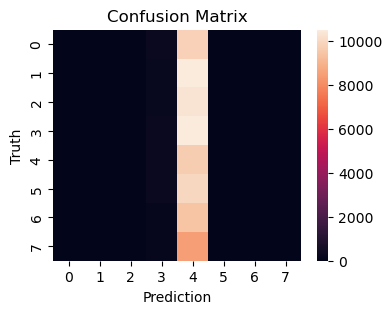

In [11]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = pd.cut(y_pred,bins=range(0,201),labels=range(1,201))

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

# Decision Tree

R2.     :  -1.0567880067249753
Accuracy:  0.1358095332868942
Recall  :  0.1358095332868942


Text(20.72222222222222, 0.5, 'Truth')

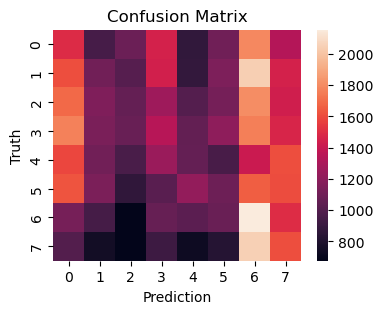

In [17]:
clf = DecisionTreeClassifier(max_depth=25)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
# print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))
# print("F1      : ", f1_score(y_test, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

In [13]:
# dot_data = export_graphviz(clf, out_file=None, 
#     feature_names=X_train.columns,  
#     class_names=[str(i) for i in y_train.unique()],  
#     filled=True, rounded=True,  
#     special_characters=False,
#     max_depth=5)
# graph = graphviz.Source(dot_data)
# graph

# Random Forest

R2.     :  -1.2556243760055676
Accuracy:  0.1308339138222709
Recall  :  0.1308339138222709


Text(20.72222222222222, 0.5, 'Truth')

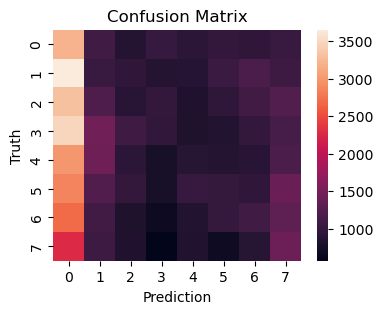

In [18]:
clf = RandomForestClassifier(n_estimators=10, max_depth=25)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
# print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")

# Dummy Classifier

[[10076     0     0     0     0     0     0     0]
 [10687     0     0     0     0     0     0     0]
 [10518     0     0     0     0     0     0     0]
 [10808     0     0     0     0     0     0     0]
 [ 9945     0     0     0     0     0     0     0]
 [10224     0     0     0     0     0     0     0]
 [ 9570     0     0     0     0     0     0     0]
 [ 8564     0     0     0     0     0     0     0]]
R2.     :  -2.274734387482363
Accuracy:  0.12533585431386207
Recall  :  0.12533585431386207


<Axes: >

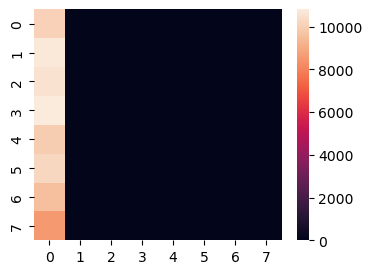

In [19]:
dummy = DummyClassifier(strategy='most_frequent', random_state=0)
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

cm = confusion_matrix(y_test, y_dummy)
print(confusion_matrix(y_test, y_dummy))
print("R2.     : ", r2_score(y_test, y_dummy))
print("Accuracy: ", accuracy_score(y_test, y_dummy))
print("Recall  : ", recall_score(y_test, y_dummy, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)

# Logistic Regression

[[2798  582  407 1338 2484  544 1883   40]
 [2958  631  284 1249 2720  687 2134   24]
 [3268  557  213 1309 2427  590 2132   22]
 [3511  560  247 1027 2700  601 2112   50]
 [2964  541  300 1102 2294  526 2130   88]
 [3116  715  315  840 2646  466 2009  117]
 [2691  405  380  924 2548  634 1913   75]
 [2333  653  359  732 2083  477 1824  103]]
R2.     :  -1.0632122580444179
Accuracy:  0.11748681460841875
Recall  :  0.11748681460841875


Text(20.72222222222222, 0.5, 'Truth')

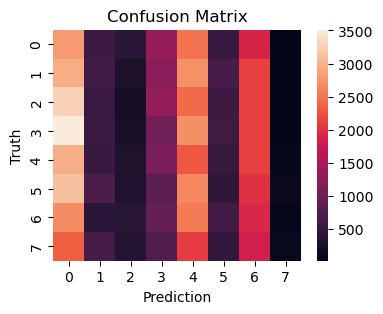

In [20]:
reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# y_pred = y_pred.astype("int64")

cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print("R2.     : ", r2_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall  : ", recall_score(y_test, y_pred, average="micro"))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
fig = plt.figure(figsize=(4, 3))
sns.heatmap(df_cm)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")